In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 6 - Attention is All You Need

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

![](https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013//assets/transformer1.png)

## Introduction

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization. 

As of January 2020, Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks and it appears as if they will be for the near future. 

The most popular Transformer variant is [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models. 

A common library used when dealing with pre-trained transformers is the [Transformers](https://huggingface.co/transformers/) library, see [here](https://huggingface.co/transformers/pretrained_models.html) for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
#from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We'll then create our tokenizers as before.

In [4]:
### Датасет RU<->EN создаем на основе корпуса QED v2.0a с ресурса https://opus.nlpl.eu/

In [5]:
!pip3 install wget

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=8f1bc523bf461b3b0297911c6d98864a7a3d762944166dd966824b8c055ab201
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
import zipfile
import gensim
import wget

!mkdir ./stepik-dl-nlp/
!mkdir ./stepik-dl-nlp/datasets/
!mkdir ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN

corpus_url = 'https://object.pouta.csc.fi/OPUS-QED/v2.0a/moses/en-ru.txt.zip'
wget.download(corpus_url, "corpus.zip")
!unzip corpus.zip -d ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN
!rm corpus.zip ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED.en-ru.xml
!ls

Archive:  corpus.zip
  inflating: ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/README  
  inflating: ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/LICENSE  
  inflating: ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED.en-ru.en  
  inflating: ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED.en-ru.ru  
  inflating: ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED.en-ru.xml  
__notebook__.ipynb  stepik-dl-nlp


In [7]:
import pandas as pd
import numpy as np

with open("./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED.en-ru.ru") as file:
    lines_ru = [line.rstrip() for line in file]
    
with open("./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED.en-ru.en") as file:
    lines_en = [line.rstrip() for line in file]

assert len(lines_ru) == len(lines_en)

In [8]:
# выяснилось, что достаточно много коротких предложений (слов) обернутых в скобки, 
# проанализировать (лучше на ранней стадии) - принято решение удалить такие строки, т.к. с ними 
# не все просто, и они как бы вырваны из контекста (урезал до того, что убираю все примеры, если 
# началом фразы на одном из языков выступает "(")
# заодно удаляем дубликаты через set
lines_en, lines_ru = zip(*set([(line_en, line_ru) for line_en, line_ru in zip(lines_en, lines_ru) \
                               if line_en[0] != '(' and line_ru[0] != '(']))

In [9]:
#проверить RU предложения на наличие английских символов и наоборот
import re
lines_en, lines_ru = zip(*set([(line_en, line_ru) for line_en, line_ru in zip(lines_en, lines_ru) \
                               if not re.search(r'\b[a-zA-Z]+\b', line_ru)]))
lines_en, lines_ru = zip(*set([(line_en, line_ru) for line_en, line_ru in zip(lines_en, lines_ru) \
                               if not re.search(r'\b[а-яА-ЯёЁ]+\b', line_en)]))

In [10]:
#удаляем строки со всякими странными/пограничными символами (жестко задаем набор символов, которые ожидаем)
lines_en, lines_ru = zip(*set([(line_en, line_ru) for line_en, line_ru in zip(lines_en, lines_ru) \
                               if not re.search(r'[^a-zA-Zа-яА-ЯёЁ\s\d\.\?!\:\-—,"`\']', line_en + line_ru)]))

In [11]:
#pd.options.display.max_colwidth = 120
df_corpus = pd.DataFrame(data={'EN': lines_en, 'RU': lines_ru})
df_corpus

,EN,RU
0,We know that you will buy more if you're depre...,"Вы больше покупаете, когда у вас депрессия."
1,There is many different aspects to free-diving.,У фридайвинга есть много разных вариантов.
2,Very good is average.,Очень хорошее средне.
3,Let's at least eat a hamburger somewhere.,Давай хотя бы гамбургер где-нибудь съедим.
4,One of the things we realized was how importan...,"К примеру, мы вдруг осознали, насколько важным..."
...,...,...
444809,And how are we going to assign what the respon...,И как мы можем определить ответственность и пр...
444810,"In India, sometimes, when it's intense, intens...","В Индии говорят, ""интенсивное"", ""интенсивно ли..."
444811,If we know that we're going to get extra bang ...,"Если бы мы знали, что получим дополнительные с..."
444812,Ultimately the true legacy that we can leave b...,"В конце концов, настоящее наше наследие, то, ч..."


In [12]:
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm

     |████████████████████████████████| 13.9 MB 522 kB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-

In [13]:
TRANSLATION_DIRECTION = 'EN->RU' # 'RU->EN' or 'EN->RU'

if TRANSLATION_DIRECTION == 'RU->EN':
    SPACY_SRC_LOAD = 'ru_core_news_sm'
elif TRANSLATION_DIRECTION == 'EN->RU':
    SPACY_SRC_LOAD = 'en_core_web_sm'
    
spacy_ru = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

#Изменяем токенизацию слов с апострофами, без этого изменения, spacy будет токенизировать так "can't" = ["ca", "n't"]
#к слову, поведение на слова без апострофов (там где они должны быть, но упущены), не измениться и будет "cant" = ["ca", "nt"] 
#
# провел экспеимент, на практике, модель с токенизацией по умолчанию (т.е. can't" = ["ca", "n't"]) дает лучшие показатели
# spacy_en.tokenizer.rules = {key: value for key, value in spacy_en.tokenizer.rules.items() if "'" not in key and "’" not in key and "‘" not in key}
# assert [t.text for t in spacy_en("can't")] == ["can't"]

In [14]:
def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [15]:
df_corpus['EN_tok'] = df_corpus.EN.apply(tokenize_en)
df_corpus['RU_tok'] = df_corpus.RU.apply(tokenize_ru)
df_corpus['EN_tok_len'] = df_corpus.EN_tok.apply(len)
df_corpus['RU_tok_len'] = df_corpus.RU_tok.apply(len)
df_corpus

,EN,RU,EN_tok,RU_tok,EN_tok_len,RU_tok_len
0,We know that you will buy more if you're depre...,"Вы больше покупаете, когда у вас депрессия.","[We, know, that, you, will, buy, more, if, you...","[Вы, больше, покупаете, ,, когда, у, вас, депр...",12,9
1,There is many different aspects to free-diving.,У фридайвинга есть много разных вариантов.,"[There, is, many, different, aspects, to, free...","[У, фридайвинга, есть, много, разных, варианто...",10,7
2,Very good is average.,Очень хорошее средне.,"[Very, good, is, average, .]","[Очень, хорошее, средне, .]",5,4
3,Let's at least eat a hamburger somewhere.,Давай хотя бы гамбургер где-нибудь съедим.,"[Let, 's, at, least, eat, a, hamburger, somewh...","[Давай, хотя, бы, гамбургер, где, -, нибудь, с...",9,9
4,One of the things we realized was how importan...,"К примеру, мы вдруг осознали, насколько важным...","[One, of, the, things, we, realized, was, how,...","[К, примеру, ,, мы, вдруг, осознали, ,, наскол...",18,17
...,...,...,...,...,...,...
444809,And how are we going to assign what the respon...,И как мы можем определить ответственность и пр...,"[And, how, are, we, going, to, assign, what, t...","[И, как, мы, можем, определить, ответственност...",22,14
444810,"In India, sometimes, when it's intense, intens...","В Индии говорят, ""интенсивное"", ""интенсивно ли...","[In, India, ,, sometimes, ,, when, it, 's, int...","[В, Индии, говорят, ,, "", интенсивное, "", ,, ""...",13,12
444811,If we know that we're going to get extra bang ...,"Если бы мы знали, что получим дополнительные с...","[If, we, know, that, we, 're, going, to, get, ...","[Если, бы, мы, знали, ,, что, получим, дополни...",80,66
444812,Ultimately the true legacy that we can leave b...,"В конце концов, настоящее наше наследие, то, ч...","[Ultimately, the, true, legacy, that, we, can,...","[В, конце, концов, ,, настоящее, наше, наследи...",20,27


<AxesSubplot:>

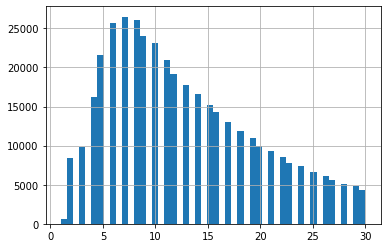

In [16]:
#проанализировать выбросы по длине токенов (обоих язаыков), убрать явные выбросы (например более 20-30 токенов)
#place of possible hyperparameters
LEN_THRESHOLD = 30
df_corpus.EN_tok_len[df_corpus.EN_tok_len <= LEN_THRESHOLD].hist(bins = 50)

In [17]:
df_corpus = df_corpus[(df_corpus.EN_tok_len <= LEN_THRESHOLD) & (df_corpus.RU_tok_len <= LEN_THRESHOLD)]

In [18]:
#проаинализировать разницы в количествах токенов параллельных предложений, убрать выбросы (например оставить в пределах mean + std)
#не учитывать слишком короткие предложения, <= 4 токена
DIFF_NO_DEL_TRESHOLD = 4
df_corpus['len_diff_ratio'] = df_corpus[["EN_tok_len", "RU_tok_len"]].max(axis=1) / df_corpus[["EN_tok_len", "RU_tok_len"]].min(axis=1)
df_corpus = df_corpus[(df_corpus['len_diff_ratio'] <= df_corpus['len_diff_ratio'].mean() + df_corpus['len_diff_ratio'].std()) | \
                      (df_corpus["EN_tok_len"] <= DIFF_NO_DEL_TRESHOLD) & (df_corpus["RU_tok_len"] <= DIFF_NO_DEL_TRESHOLD)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
# проанализировать на предмет минимального количества токенов, визуально посмотреть примеры, 
# принять решение об их использовании
df_corpus[(df_corpus.EN_tok_len < 4) | (df_corpus.RU_tok_len < 4)]

,EN,RU,EN_tok,RU_tok,EN_tok_len,RU_tok_len,len_diff_ratio
31,Stand up,Что вы скажете?,"[Stand, up]","[Что, вы, скажете, ?]",2,4,2.000000
54,Feeling ill?,Ты не заболел?,"[Feeling, ill, ?]","[Ты, не, заболел, ?]",3,4,1.333333
84,Oops.,Ой...,"[Oops, .]","[Ой, ...]",2,2,1.000000
91,- Thank you.,-Спасибо.,"[-, Thank, you, .]","[-Спасибо, .]",4,2,2.000000
102,Eat a lot.,Ешь побольше.,"[Eat, a, lot, .]","[Ешь, побольше, .]",4,3,1.333333
...,...,...,...,...,...,...,...
444674,Please!,Брось!,"[Please, !]","[Брось, !]",2,2,1.000000
444699,- Very!,- Очень!,"[-, Very, !]","[-, Очень, !]",3,3,1.000000
444722,Gone.,Стиралось.,"[Gone, .]","[Стиралось, .]",2,2,1.000000
444744,They're the people.,Это люди.,"[They, 're, the, people, .]","[Это, люди, .]",5,3,1.666667


In [20]:
#разбиваем датасет на 3-шт (train/val/test) и сохраняем в .csv для дальнейшего использования
df_corpus = df_corpus[['EN', 'RU']]

#train/val/test - 70%/25%/5%
TRAIN_VAL_TEST_RATIO = [.70, .25] #TEST = all not include to train/val

#.sample(frac=1) - предварительное перемешивание
df_train, df_val, df_test = np.split(df_corpus.sample(frac=1, random_state=42).reset_index(drop=True),
                                     [int(TRAIN_VAL_TEST_RATIO[0]*len(df_corpus)), 
                                      int(sum(TRAIN_VAL_TEST_RATIO)*len(df_corpus))])

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

#save
df_train.to_csv('./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED_train.csv', index=False)
df_val.to_csv('./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED_val.csv', index=False)
df_test.to_csv('./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED_test.csv', index=False)

#чистим исходные файлы и лишние переменные
del df_corpus, df_train, df_val, df_test, lines_en, lines_ru
!rm ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED.en-ru.ru ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED.en-ru.en
!ls -la ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/

Train: 259396, Val: 92642, Test: 18529
total 59320
drwxr-xr-x 2 root root     4096 Apr 15 08:44 .
drwxr-xr-x 3 root root     4096 Apr 15 08:41 ..
-rw-r--r-- 1 root root      391 Jul  5  2019 LICENSE
-rw-r--r-- 1 root root  3033859 Apr 15 08:44 QED_test.csv
-rw-r--r-- 1 root root 42480690 Apr 15 08:44 QED_train.csv
-rw-r--r-- 1 root root 15205080 Apr 15 08:44 QED_val.csv
-rw-r--r-- 1 root root     1445 Jul  5  2019 README


In [21]:
!head ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED_train.csv
!head ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED_val.csv
!head ./stepik-dl-nlp/datasets/OPUS-QED_RU-EN/QED_test.csv

EN,RU
Secret sports event.,Секретное спортивное мероприятие.
Smart tunnelling to get around anti-neutrality activity by upstream ISPs and other network providers.,"Смарт туннелирование, чтобы обойти анти-нейтральности деятельности вверх по течению интернет-провайдеров и других поставщиков сети."
"So, there's three main types of guitar.","Итак, три основных вида гитар."
What the hell is going on?,Какого хрена тут происходит?
I was as smelly and as depressed as anyone in line.,"И я была так же подавлена и так же воняла, как все в очереди."
"We have trained, hired and rewarded people to be cowboys.","Мы обучаем, нанимаем и поощряем людей быть ковбоями."
Maybe I'll skip this lecture.,"Может, я пропущу эту лекцию."
Just wait over there.,Подождите здесь.
Sumitra's son was Laxman Kaikeyi's son was Bharat I'm so impressed!,"Сыном Сумитры был Лакшман, и у Кейкейи был сын Бхарат. и Шатрунгхан кажется был братом Лахмана, значит он был сыном Сумитры."
EN,RU
It's about the end of an old and corrupt

Our fields are the same as the previous notebook. The model expects data to be fed in with the batch dimension first, so we use `batch_first = True`. 

In [22]:
if TRANSLATION_DIRECTION == 'RU->EN':
    SRC = Field(tokenize = tokenize_ru, 
                init_token = '<sos>', 
                eos_token = '<eos>', 
                lower = True, 
                batch_first = True)

    TRG = Field(tokenize = tokenize_en, 
                init_token = '<sos>', 
                eos_token = '<eos>', 
                lower = True, 
                batch_first = True)

    fields = {
        'RU': ('src', SRC),
        'EN': ('trg', TRG)
    }
elif TRANSLATION_DIRECTION == 'EN->RU':
    SRC = Field(tokenize = tokenize_en, 
                init_token = '<sos>', 
                eos_token = '<eos>', 
                lower = True, 
                batch_first = True)

    TRG = Field(tokenize = tokenize_ru, 
                init_token = '<sos>', 
                eos_token = '<eos>', 
                lower = True, 
                batch_first = True)

    fields = {
        'EN': ('src', SRC),
        'RU': ('trg', TRG)
    }

We then load dataset and build the vocabulary.

In [23]:
# train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
#                                                     fields = (SRC, TRG))
#TabularDataset - Defines a Dataset of columns stored in CSV, TSV, or JSON format
#TabularDataset.splits - Create Dataset objects for multiple splits of a dataset.
train_data, valid_data, test_data = TabularDataset.splits(
                            path = './stepik-dl-nlp/datasets/OPUS-QED_RU-EN/',
                            train = 'QED_train.csv',
                            validation = 'QED_val.csv',
                            test = 'QED_test.csv',
                            format = 'csv',
                            fields = fields
)

In [24]:
for i in range(3):
    print(' '.join(train_data.examples[i].src))
    print(train_data.examples[i].src)
    print(' '.join(train_data.examples[i].trg))
    print(train_data.examples[i].trg)
    print()

secret sports event .
['secret', 'sports', 'event', '.']
секретное спортивное мероприятие .
['секретное', 'спортивное', 'мероприятие', '.']

smart tunnelling to get around anti - neutrality activity by upstream isps and other network providers .
['smart', 'tunnelling', 'to', 'get', 'around', 'anti', '-', 'neutrality', 'activity', 'by', 'upstream', 'isps', 'and', 'other', 'network', 'providers', '.']
смарт туннелирование , чтобы обойти анти - нейтральности деятельности вверх по течению интернет - провайдеров и других поставщиков сети .
['смарт', 'туннелирование', ',', 'чтобы', 'обойти', 'анти', '-', 'нейтральности', 'деятельности', 'вверх', 'по', 'течению', 'интернет', '-', 'провайдеров', 'и', 'других', 'поставщиков', 'сети', '.']

so , there 's three main types of guitar .
['so', ',', 'there', "'s", 'three', 'main', 'types', 'of', 'guitar', '.']
итак , три основных вида гитар .
['итак', ',', 'три', 'основных', 'вида', 'гитар', '.']



In [25]:
#.build_vocab - Construct the Vocab object for this field from one or more datasets.

SRC.build_vocab(train_data, min_freq = 2)
print(SRC.vocab.freqs.most_common(20))

TRG.build_vocab(train_data, min_freq = 2)
print(TRG.vocab.freqs.most_common(20))

print(f"Первые 10 токенов: {SRC.vocab.itos[:10]}")

print(f"Уникальные токены в словаре SRC (train): {len(SRC.vocab)}")
print(f"Уникальные токены в словаре TRG (train): {len(TRG.vocab)}")

[('.', 204409), (',', 154737), ('the', 129751), ('and', 76528), ('to', 75095), ('of', 63377), ('a', 62329), ('i', 58706), ('you', 58073), ('that', 52193), ('it', 52148), ('is', 47532), ('in', 41463), ("'s", 40810), ('we', 39627), ('this', 34432), ('?', 29799), ('so', 26296), ('"', 24318), ('do', 21085)]
[(',', 226815), ('.', 205165), ('и', 67366), ('в', 59013), ('что', 49049), ('это', 45373), ('я', 44871), ('не', 38640), ('"', 32921), ('-', 32753), ('?', 30073), ('на', 29555), ('мы', 28423), ('как', 20353), ('вы', 20210), ('с', 19256), ('то', 14914), ('но', 14691), ('!', 14394), ('так', 13998)]
Первые 10 токенов: ['<unk>', '<pad>', '<sos>', '<eos>', '.', ',', 'the', 'and', 'to', 'of']
Уникальные токены в словаре SRC (train): 31027
Уникальные токены в словаре TRG (train): 71604


In [26]:
print(f"Размер обучающей выборки: {len(train_data.examples)}")
print(f"Размер валидационной выборки: {len(valid_data.examples)}")
print(f"Размер тестовой выборки: {len(test_data.examples)}")

Размер обучающей выборки: 259396
Размер валидационной выборки: 92642
Размер тестовой выборки: 18529


SRC:


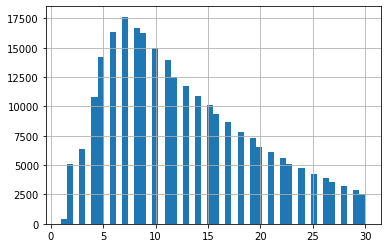

TRG:


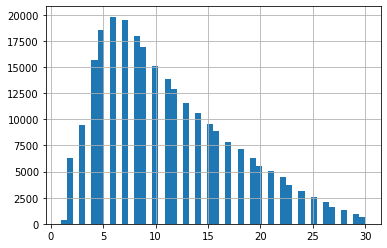

SRC:


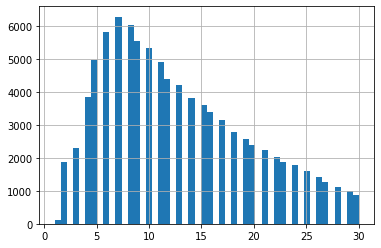

TRG:


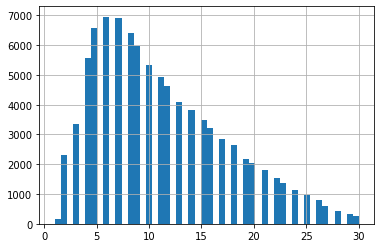

SRC:


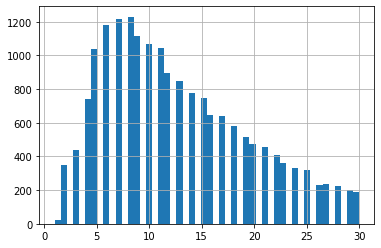

TRG:


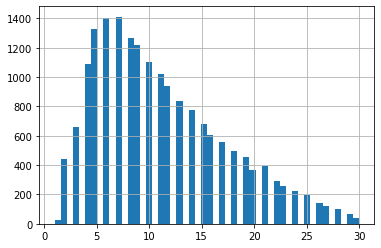

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

for data in [train_data, valid_data, test_data]:
    print("SRC:")
    pd.Series([len(example.src) for example in data.examples]).hist(bins=50)
    plt.show()
    print("TRG:")
    pd.Series([len(example.trg) for example in data.examples]).hist(bins=50)
    plt.show()

Finally, we define the device and the data iterator.

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
#place of possible hyperparameters
BATCH_SIZE = 128

'''
BucketIterator - Defines an iterator that batches examples of similar lengths together. (т.е. схожей длины, это суть выбора BucketIterator)
Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch. See pool for the bucketing procedure used.

Итого, генерирует батчи тензоров равной длины (из индексов токенов), длина берется максимальная из примеров попавших в батч 
(если sort = True и/или sort_within_batch = True, то батчи формируются после предварительной сортировки по размеру), все примеры меньшей длины
добиваются до необходимой через токен паддинга (<pad>, id=1)

Судя по документации, sort_within_batch - отвечает только за необходимость сортировки внутри батчей, и не должен влиять на суть BucketIterator, 
а именно объединение в батчи на основе длины, но по факту влияет, если выставить False и не будет параметра sort = True, то примеры будут 
объединяться в батч рандомно, единственное, что дополнительно будет делать BucketIterator - это добивать до общей максимальной длины паддингами
(что бы убрать неоднозначности, явно добавил еще и параметр sort = True)

P.S. sort_within_batch нужно для упаковки PackedSequence, если батч не будет отсортирован по убыванию длины, то нужно при упаковке в 
PackedSequence, использовать параметр enforce_sorted = False (не изучал подробно на что это влияет)
'''
SORT_BY_SEQLENGTH = False

if SORT_BY_SEQLENGTH:
    #параметров sort = True, sort_within_batch = True, sort_key = lambda x : len(x.src), не было в данной реализации (добавил) из (seq2seq StackOvf)
    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data),
         batch_size = BATCH_SIZE,
         sort = True,
         sort_within_batch = True,
         sort_key = lambda x : len(x.src),
         device = device)
else:
#без сортировки
    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data),
         batch_size = BATCH_SIZE,
         sort = False,
         device = device)

# for batch in test_iterator:
#     print(batch.src.shape)
# batch.src

## Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

### Encoder

Similar to the ConvSeq2Seq model, the Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

![](https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013//assets/transformer-encoder.png)

First, the tokens are passed through a standard embedding layer. Next, as the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the `<sos>` (start of sequence) token, in position 0. The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.

The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use positional embeddings instead, hence we have decided to use them in these tutorials. Check out [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) section to read more about the positional embeddings used in the original Transformer model.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, `hid_dim`. This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.

The combined embeddings are then passed through $N$ *encoder layers* to get $Z$, which is then output and can be used by the decoder.

The source mask, `src_mask`, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens, which contain no useful information.

In [30]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

The encoder layers are where all of the "meat" of the encoder is contained. We first pass the source sentence and its mask into the *multi-head attention layer*, then perform dropout on it, apply a residual connection and pass it through a [Layer Normalization](https://arxiv.org/abs/1607.06450) layer. We then pass it through a *position-wise feedforward* layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer. The parameters are not shared between layers. 

The mutli head attention layer is used by the encoder layer to attend to the source sentence, i.e. it is calculating and applying attention over itself instead of another sequence, hence we call it *self attention*.

[This](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) article goes into more detail about layer normalization, but the gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

In [31]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

![](https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013//assets/transformer-attention.png)

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`. 

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

In [32]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

The other main block inside the encoder layer is the *position-wise feedforward layer* This is relatively simple compared to the multi-head attention layer. The input is transformed from `hid_dim` to `pf_dim`, where `pf_dim` is usually a lot larger than `hid_dim`. The original Transformer used a `hid_dim` of 512 and a `pf_dim` of 2048. The ReLU activation function and dropout are applied before it is transformed back into a `hid_dim` representation. 

Why is this used? Unfortunately, it is never explained in the paper.

BERT uses the [GELU](https://arxiv.org/abs/1606.08415) activation function, which can be used by simply switching `torch.relu` for `F.gelu`. Why did they use GELU? Again, it is never explained.

In [33]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 

![](https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013//assets/transformer-decoder.png)

The decoder is similar to encoder, however it now has two multi-head attention layers. A *masked multi-head attention layer* over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value.

The decoder uses positional embeddings and combines - via an elementwise sum - them with the scaled embedded target tokens, followed by dropout. Again, our positional encodings have a "vocabulary" of 100, which means they can accept sequences up to 100 tokens long. This can be increased if desired.

The combined embeddings are then passed through the $N$ decoder layers, along with the encoded source, `enc_src`, and the source and target masks. Note that the number of layers in the encoder does not have to be equal to the number of layers in the decoder, even though they are both denoted by $N$.

The decoder representation after the $N^{th}$ layer is then passed through a linear layer, `fc_out`. In PyTorch, the softmax operation is contained within our loss function, so we do not explicitly need to use a softmax layer here.

As well as using the source mask, as we did in the encoder to prevent our model attending to `<pad>` tokens, we also use a target mask. This will be explained further in the `Seq2Seq` model which encapsulates both the encoder and decoder, but the gist of it is that it performs a similar operation as the decoder padding in the convolutional sequence-to-sequence model. As we are processing all of the target tokens at once in parallel we need a method of stopping the decoder from "cheating" by simply "looking" at what the next token in the target sequence is and outputting it. 

Our decoder layer also outputs the normalized attention values so we can later plot them to see what our model is actually paying attention to.

In [34]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

As mentioned previously, the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, `self_attention` and `encoder_attention`. 

The first performs self-attention, as in the encoder, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization. This `self_attention` layer uses the target sequence mask, `trg_mask`, in order to prevent the decoder from "cheating" by paying attention to tokens that are "ahead" of the one it is currently processing as it processes all tokens in the target sentence in parallel.

The second is how we actually feed the encoded source sentence, `enc_src`, into our decoder. In this multi-head attention layer the queries are the decoder representations and the keys and values are the encoder representations. Here, the source mask, `src_mask` is used to prevent the multi-head attention layer from attending to `<pad>` tokens within the source sentence. This is then followed by the dropout, residual connection and layer normalization layers. 

Finally, we pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

The decoder layer isn't introducing any new concepts, just using the same set of layers as the encoder in a slightly different way.

In [35]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [36]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [37]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [38]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 48,680,628 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [40]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [41]:
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [42]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [43]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [44]:
def train(model, iterator, optimizer, criterion, clip):
    '''
    Upd:
        - add return max norm gradient before clip
    '''
    
    model.train()
    
    epoch_loss = 0
    
    max_grad_norm = 0.0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        curr_grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        max_grad_norm = max(max_grad_norm, curr_grad_norm)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), max_grad_norm

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [45]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [46]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [47]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, max_grad_norm = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
        saved_best_model = True
    else:
        saved_best_model = False
    
    print('Epoch: {:02} Time: {}m {}s | Train: Loss = {:.3f}  PPL = {:7.3f} | Val: Loss = {:.3f}  PPL = {:7.3f} | MaxGradN = {:.3f}, SAVE = {}'.format(
         epoch+1,
         epoch_mins,
         epoch_secs,
         train_loss,
         math.exp(train_loss),
         valid_loss,
         math.exp(valid_loss),
         max_grad_norm,
         saved_best_model))

Epoch: 01 Time: 5m 29s | Train: Loss = 5.058  PPL = 157.260 | Val: Loss = 3.927  PPL =  50.767 | MaxGradN = 2.793, SAVE = True
Epoch: 02 Time: 5m 29s | Train: Loss = 3.649  PPL =  38.427 | Val: Loss = 3.271  PPL =  26.335 | MaxGradN = 1.991, SAVE = True
Epoch: 03 Time: 5m 28s | Train: Loss = 2.948  PPL =  19.076 | Val: Loss = 3.018  PPL =  20.443 | MaxGradN = 2.082, SAVE = True
Epoch: 04 Time: 5m 28s | Train: Loss = 2.491  PPL =  12.071 | Val: Loss = 2.922  PPL =  18.585 | MaxGradN = 1.991, SAVE = True
Epoch: 05 Time: 5m 28s | Train: Loss = 2.164  PPL =   8.706 | Val: Loss = 2.935  PPL =  18.827 | MaxGradN = 2.196, SAVE = False
Epoch: 06 Time: 5m 28s | Train: Loss = 1.920  PPL =   6.822 | Val: Loss = 2.973  PPL =  19.558 | MaxGradN = 2.070, SAVE = False
Epoch: 07 Time: 5m 28s | Train: Loss = 1.736  PPL =   5.676 | Val: Loss = 3.036  PPL =  20.814 | MaxGradN = 2.166, SAVE = False
Epoch: 08 Time: 5m 28s | Train: Loss = 1.593  PPL =   4.919 | Val: Loss = 3.105  PPL =  22.316 | MaxGradN = 

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [48]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.917 | Test PPL:  18.485 |


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [49]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50, 
                       spacy_src_load = 'en_core_web_sm'):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load(spacy_src_load)
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [50]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [51]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['sumitra', "'s", 'son', 'was', 'laxman', 'kaikeyi', "'s", 'son', 'was', 'bharat', 'i', "'m", 'so', 'impressed', '!']
trg = ['сыном', 'сумитры', 'был', 'лакшман', ',', 'и', 'у', 'кейкейи', 'был', 'сын', 'бхарат', '.', 'и', 'шатрунгхан', 'кажется', 'был', 'братом', 'лахмана', ',', 'значит', 'он', 'был', 'сыном', 'сумитры', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [52]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['сын', 'был', 'сыном', '<unk>', '<unk>', ',', 'я', 'так', 'сильно', '<unk>', '!', '<eos>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


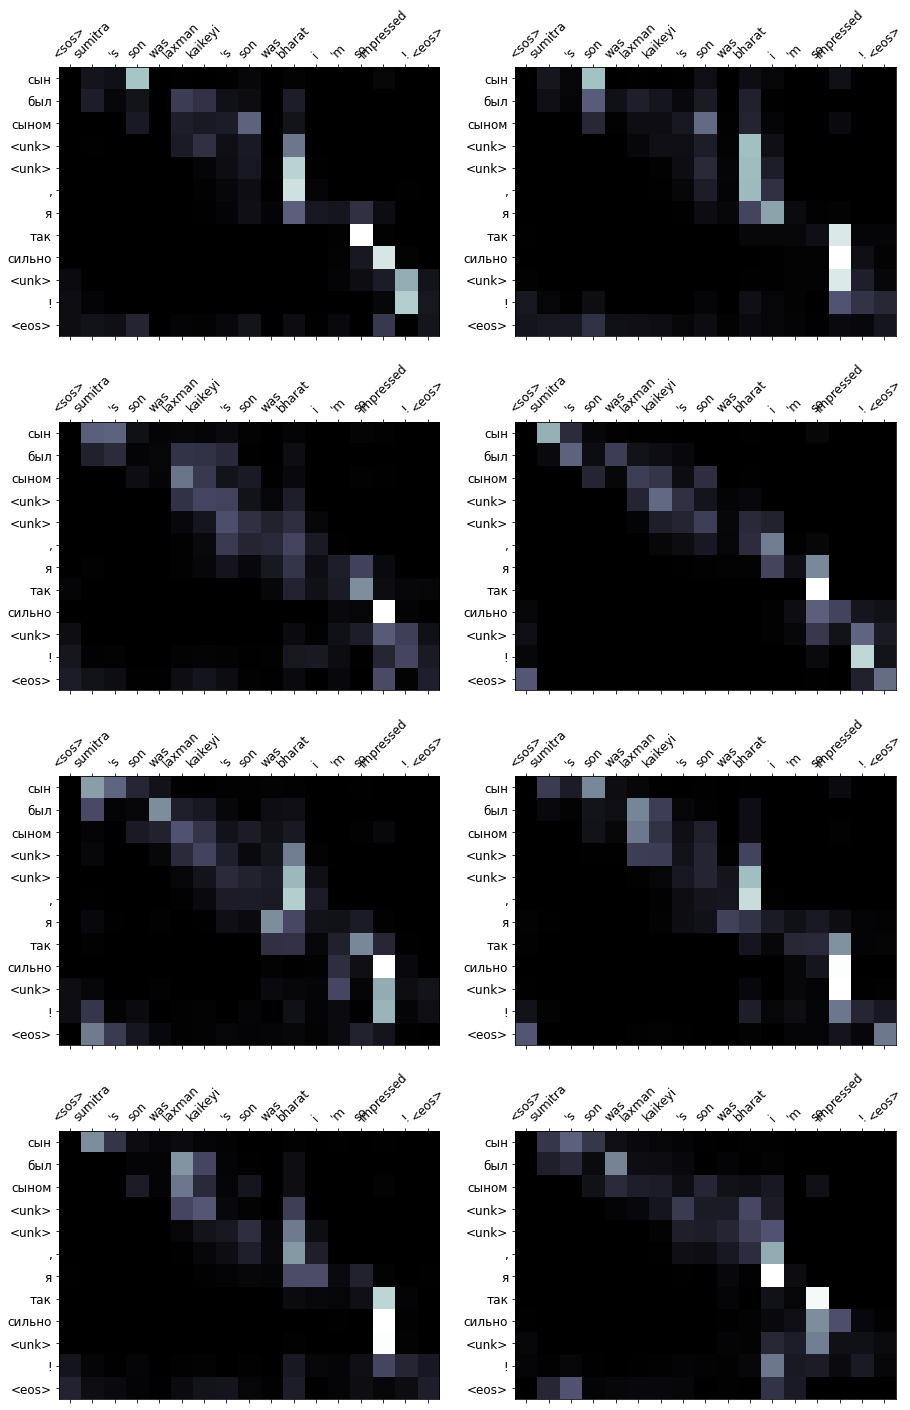

In [53]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [54]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['i', 'told', 'the', 'warden', 'that', 'i', 'wanted', 'to', 'start', 'a', 'mountain', 'biking', 'club', 'in', 'this', 'place', 'and', 'that', 'basically', 'i', 'wanted', 'to', 'take', 'the', 'kids', 'from', 'here', 'to', 'there', '.']
trg = ['я', 'предложил', 'ему', 'организовать', 'клуб', 'горного', 'велосипедизма', 'для', 'заключенных', 'и', 'сказал', ',', 'что', 'я', 'буду', 'брать', 'их', 'с', 'собой', 'в', 'горные', 'поездки', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [55]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['я', 'сказал', ',', 'что', 'хочу', 'начать', 'с', '<unk>', '<unk>', 'на', 'этом', 'месте', ',', 'и', 'я', 'хочу', 'взять', 'детей', 'отсюда', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


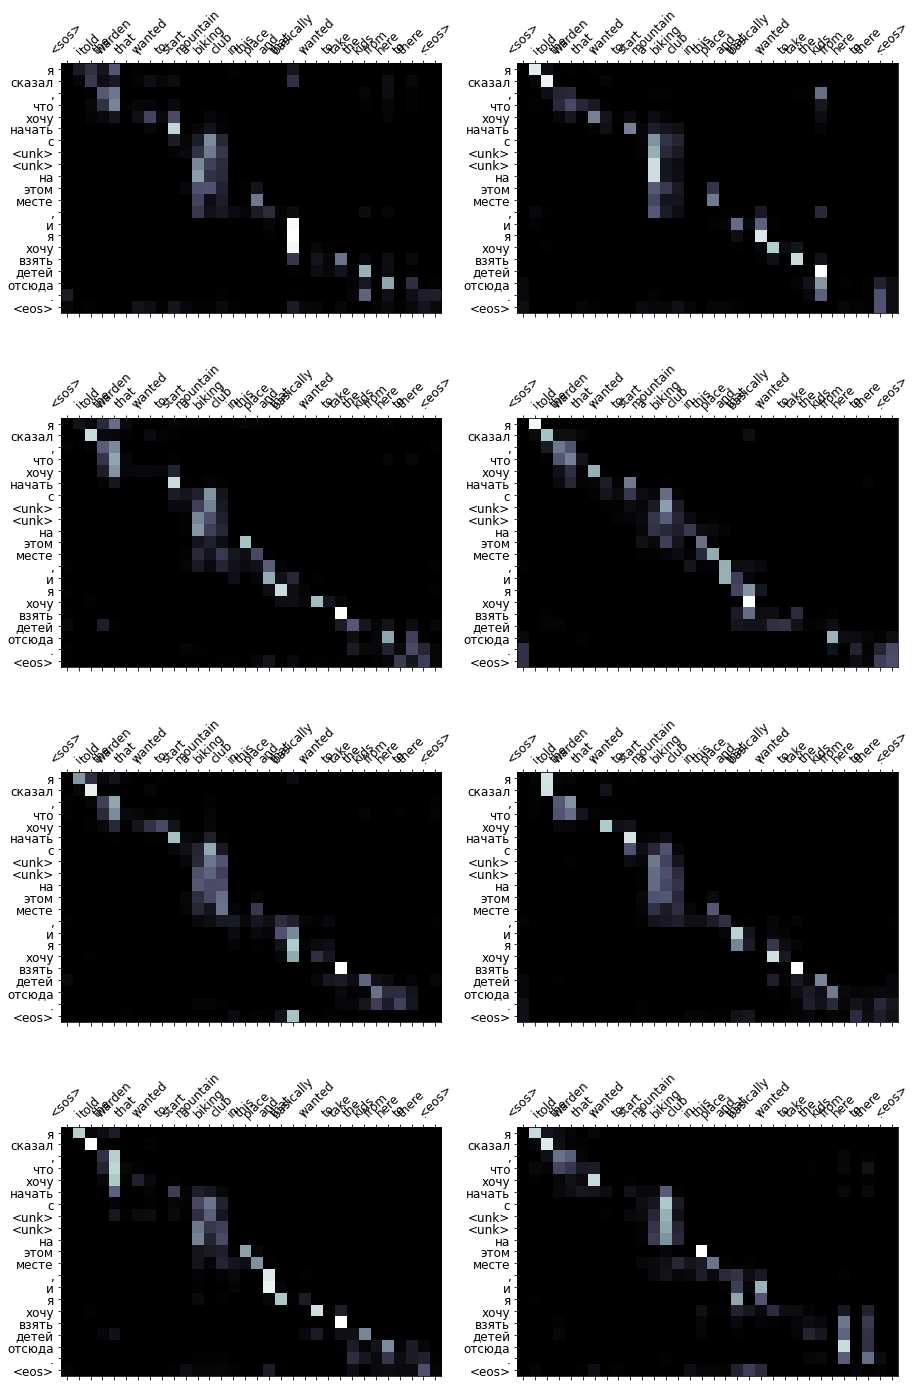

In [56]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [57]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['i', 'will', 'do', 'it', '.']
trg = ['я', 'сделаю', 'это', '.']


A perfect translation!

In [58]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['я', 'сделаю', 'это', '.', '<eos>']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


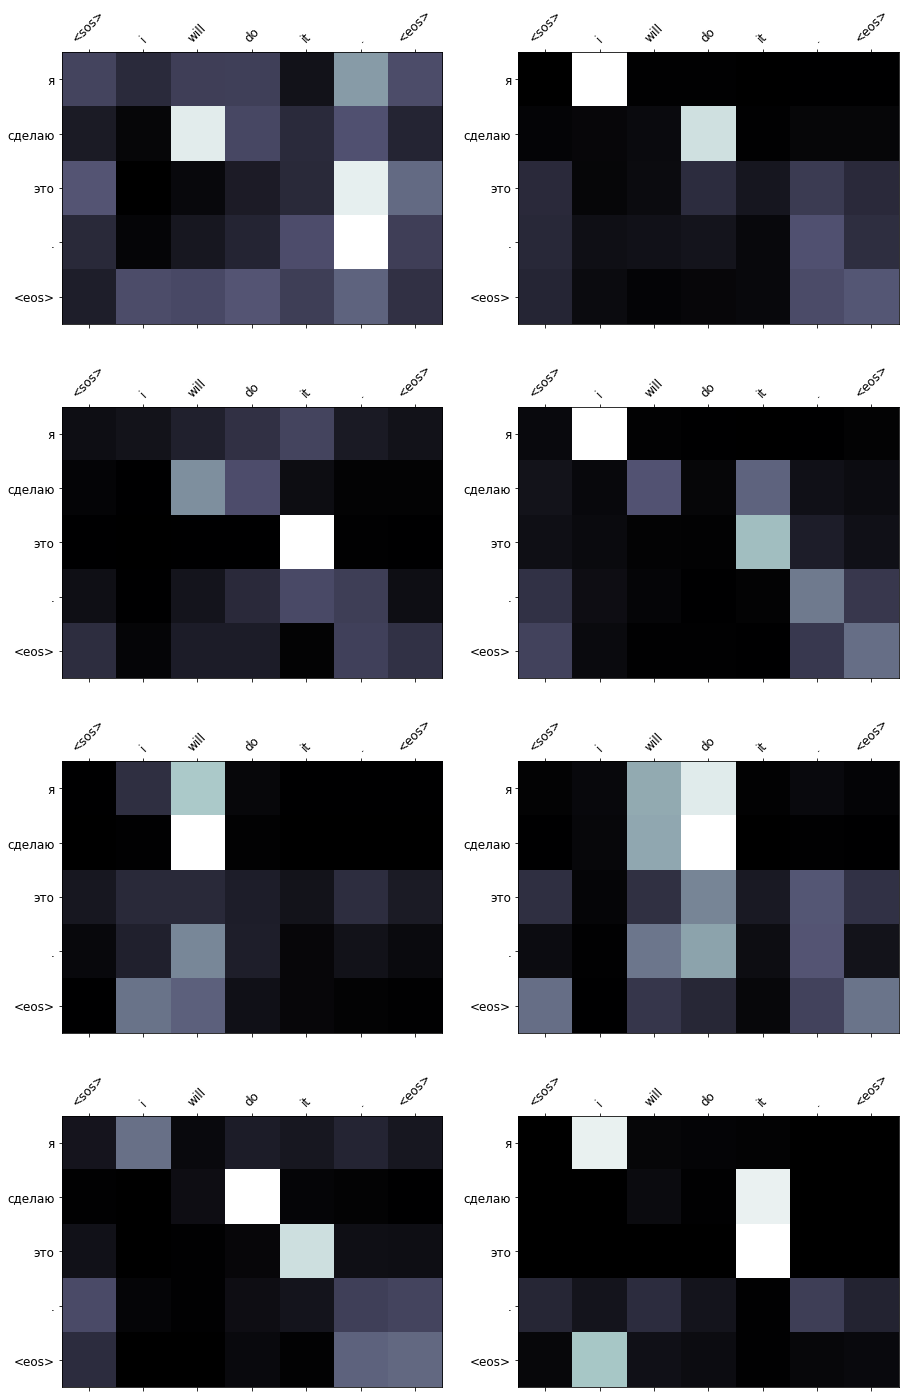

In [59]:
display_attention(src, translation, attention)

In [60]:
for example in train_data.examples[::len(train_data)//5]:

    src = ' '.join(vars(example)['src'])
    trg = ' '.join(vars(example)['trg'])

    print(f'src = {src}')
    print(f'true trg = {trg}')

    translation, attention = translate_sentence(src, SRC, TRG, model, device)
    print(f'pred trg = {" ".join(translation)}')
    
    print('---------------------------------------------------------')
    print()

src = secret sports event .
true trg = секретное спортивное мероприятие .
pred trg = секрет спорта . <eos>
---------------------------------------------------------

src = and it does that with a certain probability .
true trg = и он делает это с некоторой вероятностью .
pred trg = и это делает с определенного результата . <eos>
---------------------------------------------------------

src = now let 's see if you will be faithful to that , to honor that .
true trg = теперь посмотрим , будешь ли ты верна этому , будешь ли относиться с почтением к этому .
pred trg = теперь давайте посмотрим , если вы будете верным этому , для этого . <eos>
---------------------------------------------------------

src = answer me . do you regret it ?
true trg = скажи , не жалеешь ?
pred trg = я хочу , чтобы вы <unk> его ? <eos>
---------------------------------------------------------

src = now , we can use the tools of the 21st century to try and observe what is , rather than ask what should be , beli

In [61]:
for example in valid_data.examples[::len(valid_data)//5]:

    src = ' '.join(vars(example)['src'])
    trg = ' '.join(vars(example)['trg'])

    print(f'src = {src}')
    print(f'true trg = {trg}')

    translation, attention = translate_sentence(src, SRC, TRG, model, device)
    print(f'pred trg = {" ".join(translation)}')
    
    print('---------------------------------------------------------')
    print()

src = it 's about the end of an old and corrupt order in the world
true trg = это только конец старого , коррумпированного мира .
pred trg = это примерно конец старого и <unk> порядок в мире <eos>
---------------------------------------------------------

src = have you thought about your subtext , your hopes , your wishes , your family history , anything ?
true trg = ты думал о своей предыстории , о своих мечтах и желаниях ? ты думал хоть о чём - то ?
pred trg = вы думали о ваших <unk> , ваши надежды , ваши желания , ваша семья , ваша история , что - то ? <eos>
---------------------------------------------------------

src = -exactly ..
true trg = -точно ..
pred trg = <unk> .. <eos>
---------------------------------------------------------

src = image removed at request of owner .
true trg = изображение удалено по просьбе владельца .
pred trg = изображение олова для помощника . <eos>
---------------------------------------------------------

src = in some old cartoons from the 50s , 

In [62]:
for example in test_data.examples[::len(test_data)//10]:

    src = ' '.join(vars(example)['src'])
    trg = ' '.join(vars(example)['trg'])

    print(f'src = {src}')
    print(f'true trg = {trg}')

    translation, attention = translate_sentence(src, SRC, TRG, model, device)
    print(f'pred trg = {" ".join(translation)}')
    
    print('---------------------------------------------------------')
    print()

src = how do we tackle things like mobility ?
true trg = как мы справимся с такими вещами как мобильность ?
pred trg = как мы будем делать вещи как мобильность , как транспорт ? <eos>
---------------------------------------------------------

src = romeo my dear ?
true trg = ромео мой дорогой ?
pred trg = ромео мой дорогой ? <eos>
---------------------------------------------------------

src = in order to really understand how they do that , you have to look underneath the hood and see what 's going on .
true trg = чтобы действительно понять , как все это работает , нам нужно заглянуть под капот и посмотреть , что там происходит .
pred trg = для того , чтобы понять , как они делают это , вы должны смотреть под <unk> и увидеть , что происходит . <eos>
---------------------------------------------------------

src = everyone in your country has been touched by the violence , the bloodshed , the pain , the horror , everybody .
true trg = насилие коснулось каждого человека в вашей стране 

### Свои примеры

In [63]:
if TRANSLATION_DIRECTION == 'RU->EN':
    custom_samples = ['Это было круто!',
                      'Зачем мне это нужно?',
                      'Ура, переводчик работает!',
                      'Вчера мы ходили в магазин, цены пугают.',
                      'Работай больше, получай меньше!',
                      'Надеемся на Ваше понимание и приносим извинения за возможные неудобства.',
                      'Квартира',
                      'Кошка гуляет сама по себе.',
                      'Курс будет полезен разработчикам независимо от уровня подготовки.',
                      'Никогда не сдавайся, всегда есть третья альтернатива.']
elif TRANSLATION_DIRECTION == 'EN->RU':
    custom_samples = ['Previously we have only cared about the loss/perplexity of the model.',
                      'Congratulations for finishing these tutorials! ',
                      "I hope you've found them useful.",
                      "In so far as our client's record in boxing is concerned, he is proud of his record in boxing to date.",
                      'A threat to the entire licit economy.',
                      'Yes, you may be familiar with how to operate your car.',
                      'We just hope you also know how to change the tires on your vehicle.',
                      'Cat and dog.',
                      'Hello!',
                      'Hello world!']


for src in custom_samples:
    translation, attention = translate_sentence(src, SRC, TRG, model, device, spacy_src_load = SPACY_SRC_LOAD)
    print(f'src = {src}')
    print(f'pred trg = {" ".join(translation)}')
    print('----------------------------------------------------')

src = Previously we have only cared about the loss/perplexity of the model.
pred trg = ранее мы были только о <unk> <unk> <unk> <unk> модели . <eos>
----------------------------------------------------
src = Congratulations for finishing these tutorials! 
pred trg = поздравляю , что эти уроки ! <eos>
----------------------------------------------------
src = I hope you've found them useful.
pred trg = я надеюсь , что вы нашли их полезной . <eos>
----------------------------------------------------
src = In so far as our client's record in boxing is concerned, he is proud of his record in boxing to date.
pred trg = в то время как наш клиент <unk> <unk> , он горжусь своим <unk> в течение встречи . <eos>
----------------------------------------------------
src = A threat to the entire licit economy.
pred trg = угроза всей экономики <unk> . <eos>
----------------------------------------------------
src = Yes, you may be familiar with how to operate your car.
pred trg = да , вы можете быть 

## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

Finally we calculate the BLEU score for the Transformer.

In [64]:
from torchtext.data.metrics import bleu_score
import nltk

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 30):
# Добавил дополнительный score, полученный через nltk, т.к. важной особенностью настроек 
# по умолчанию является то, что в оценке используются 1,2,3,4-граммы, и если в предсказанном 
# предложении менее 4 токенов, то скоры torch и nltk будут вести себя по разному; torch 
# вернет 0.0 для такого предсказания, а nltk посчитает реальный скор без учета невозможных 
# n-грамм (при этом дополнительно выведет warning)

    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs), nltk.translate.bleu_score.corpus_bleu(trgs, pred_trgs)

We get a BLEU score of 36.52, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

This number isn't really interpretable, we can't really say much about it. The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the **higher** BLEU score is "better".

Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [65]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=30):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [66]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 30):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            #print('Checkout01')
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    #print('Checkout02')
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)

In [67]:
%%time
_, _, bleu_score_torch = calculate_bleu_alt(test_iterator, SRC, TRG, model, device)

print(f'BLEU score (torch) = {bleu_score_torch*100:.2f}')

BLEU score (torch) = 17.26
CPU times: user 3min 32s, sys: 144 ms, total: 3min 32s
Wall time: 3min 33s
